# Teste t para Análise de Campanhas A/B

**Autor:** Jesse Fernandes

**Data:** 2025-09-29

## Introdução

Este notebook demonstra uma implementação profissional de testes t para análise de campanhas A/B.

In [1]:
# Importações básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional, Union, Any
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import TTestIndPower, TTestPower
from sklearn.preprocessing import StandardScaler

@dataclass
class TTestResult:
    """Classe para armazenar os resultados de um teste t."""
    t_stat: float
    p_value: float
    mean_diff: float
    ci_low: float
    ci_high: float
    df: float
    test_type: str
    equal_var: bool = True
    effect_size: Optional[float] = None
    effect_size_type: Optional[str] = None
    normality_test: Optional[Dict[str, Dict[str, float]]] = None
    homogeneity_test: Optional[Dict[str, float]] = None
    
    def is_significant(self, alpha: float = 0.05) -> bool:
        """Verifica se o resultado é estatisticamente significativo."""
        return self.p_value < alpha
    
    def summary(self) -> str:
        """Retorna um resumo textual do resultado do teste."""
        sig_str = "é" if self.is_significant() else "não é"
        
        summary_text = [
            f"Tipo de teste: {self.test_type}",
            f"Estatística t: {self.t_stat:.4f}",
            f"Valor-p: {self.p_value:.4f}",
            f"Diferença média: {self.mean_diff:.4f}",
            f"Intervalo de confiança (95%): [{self.ci_low:.4f}, {self.ci_high:.4f}]",
            f"Graus de liberdade: {self.df:.1f}",
            f"Resultado: A diferença {sig_str} estatisticamente significativa (α = 0.05)."
        ]
        
        if self.effect_size is not None:
            summary_text.append(f"Tamanho do efeito ({self.effect_size_type}): {self.effect_size:.4f}")
            
        return "\n".join(summary_text)

In [3]:
class CampaignDataManager:
    """Classe para gerenciar dados de campanhas A/B."""
    
    def __init__(self, data: Optional[pd.DataFrame] = None, group_col: str = 'group', 
                 metric_col: str = 'metric', group_a: str = 'A', group_b: str = 'B'):
        """Inicializa o gerenciador de dados de campanhas A/B.
        
        Args:
            data: DataFrame com os dados da campanha
            group_col: Nome da coluna que identifica os grupos (A/B)
            metric_col: Nome da coluna que contém a métrica de resultado
            group_a: Valor que identifica o grupo A
            group_b: Valor que identifica o grupo B
        """
        self.data = data
        self.group_col = group_col
        self.metric_col = metric_col
        self.group_a = group_a
        self.group_b = group_b
        
    def load_data(self, file_path: str) -> 'CampaignDataManager':
        """Carrega dados de um arquivo CSV."""
        self.data = pd.read_csv(file_path)
        return self
    
    def generate_synthetic_data(self, n_samples_a: int = 500, n_samples_b: int = 500, 
                               mean_a: float = 50, mean_b: float = 55, 
                               std_a: float = 10, std_b: float = 10) -> 'CampaignDataManager':
        """Gera dados sintéticos para uma campanha A/B.
        
        Args:
            n_samples_a: Número de amostras para o grupo A
            n_samples_b: Número de amostras para o grupo B
            mean_a: Média do grupo A
            mean_b: Média do grupo B
            std_a: Desvio padrão do grupo A
            std_b: Desvio padrão do grupo B
        """
        group_a_data = np.random.normal(mean_a, std_a, n_samples_a)
        group_b_data = np.random.normal(mean_b, std_b, n_samples_b)
        
        self.data = pd.DataFrame({
            self.group_col: [self.group_a] * n_samples_a + [self.group_b] * n_samples_b,
            self.metric_col: np.concatenate([group_a_data, group_b_data])
        })
        return self
    
    def get_group_data(self, group: str) -> np.ndarray:
        """Retorna os dados de um grupo específico."""
        if self.data is None:
            raise ValueError("Dados não carregados. Use load_data() ou generate_synthetic_data().")
        
        return self.data[self.data[self.group_col] == group][self.metric_col].values
    
    def get_groups_data(self) -> Tuple[np.ndarray, np.ndarray]:
        """Retorna os dados dos grupos A e B."""
        return self.get_group_data(self.group_a), self.get_group_data(self.group_b)
    
    def get_summary_statistics(self) -> pd.DataFrame:
        """Retorna estatísticas descritivas por grupo."""
        if self.data is None:
            raise ValueError("Dados não carregados. Use load_data() ou generate_synthetic_data().")
        
        return self.data.groupby(self.group_col)[self.metric_col].agg([
            'count', 'mean', 'std', 'min', 'median', 'max',
            lambda x: np.percentile(x, 25),
            lambda x: np.percentile(x, 75)
        ]).rename(columns={'<lambda_0>': 'q1', '<lambda_1>': 'q3'})

In [4]:
class TTestAnalyzer:
    """Classe para realizar testes t e verificar pressupostos."""
    
    def __init__(self, data_manager: CampaignDataManager):
        """Inicializa o analisador de testes t.
        
        Args:
            data_manager: Instância de CampaignDataManager com os dados da campanha
        """
        self.data_manager = data_manager
        
    def check_normality(self, method: str = 'shapiro') -> Dict[str, Dict[str, float]]:
        """Verifica a normalidade dos dados em cada grupo.
        
        Args:
            method: Método para teste de normalidade ('shapiro', 'ks', 'anderson')
            
        Returns:
            Dicionário com resultados do teste de normalidade por grupo
        """
        group_a_data, group_b_data = self.data_manager.get_groups_data()
        results = {}
        
        for name, data in [(self.data_manager.group_a, group_a_data), 
                           (self.data_manager.group_b, group_b_data)]:
            if method == 'shapiro':
                stat, p_value = stats.shapiro(data)
                results[name] = {'statistic': stat, 'p_value': p_value}
            elif method == 'ks':
                stat, p_value = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data)))
                results[name] = {'statistic': stat, 'p_value': p_value}
            elif method == 'anderson':
                result = stats.anderson(data, 'norm')
                results[name] = {'statistic': result.statistic, 'critical_values': result.critical_values}
            else:
                raise ValueError(f"Método '{method}' não suportado. Use 'shapiro', 'ks', ou 'anderson'.")
                
        return results
    
    def check_homogeneity_of_variance(self) -> Dict[str, float]:
        """Verifica a homogeneidade das variâncias entre os grupos.
        
        Returns:
            Dicionário com resultado do teste de Levene
        """
        group_a_data, group_b_data = self.data_manager.get_groups_data()
        stat, p_value = stats.levene(group_a_data, group_b_data)
        return {'statistic': stat, 'p_value': p_value}
    
    def run_independent_ttest(self, equal_var: bool = True, alpha: float = 0.05) -> TTestResult:
        """Realiza um teste t para amostras independentes.
        
        Args:
            equal_var: Se True, assume variâncias iguais (teste t de Student),
                      caso contrário, usa o teste t de Welch
            alpha: Nível de significância
            
        Returns:
            Objeto TTestResult com os resultados do teste
        """
        group_a_data, group_b_data = self.data_manager.get_groups_data()
        
        # Verifica pressupostos
        normality_test = self.check_normality()
        homogeneity_test = self.check_homogeneity_of_variance()
        
        # Se falhar no teste de homogeneidade das variâncias, sugere usar equal_var=False
        if homogeneity_test['p_value'] < alpha and equal_var:
            warnings.warn("As variâncias não são homogêneas. Considere usar equal_var=False para o teste t de Welch.")
        
        # Realiza o teste t
        t_stat, p_value = stats.ttest_ind(group_a_data, group_b_data, equal_var=equal_var)
        
        # Calcula diferença média e intervalo de confiança
        mean_diff = np.mean(group_a_data) - np.mean(group_b_data)
        
        if equal_var:
            # Graus de liberdade para variâncias iguais
            df = len(group_a_data) + len(group_b_data) - 2
            # Pooled standard deviation
            s_pooled = np.sqrt(((len(group_a_data) - 1) * np.var(group_a_data, ddof=1) + 
                               (len(group_b_data) - 1) * np.var(group_b_data, ddof=1)) / df)
            # Standard error of difference between means
            se_diff = s_pooled * np.sqrt(1/len(group_a_data) + 1/len(group_b_data))
            test_type = "Teste t de Student para amostras independentes"
        else:
            # Graus de liberdade para variâncias desiguais (aproximação de Welch-Satterthwaite)
            var_a = np.var(group_a_data, ddof=1)
            var_b = np.var(group_b_data, ddof=1)
            n_a = len(group_a_data)
            n_b = len(group_b_data)
            
            df = ((var_a/n_a + var_b/n_b)**2) / ((var_a/n_a)**2/(n_a-1) + (var_b/n_b)**2/(n_b-1))
            # Standard error of difference between means
            se_diff = np.sqrt(var_a/n_a + var_b/n_b)
            test_type = "Teste t de Welch para amostras independentes"
            
        # Intervalo de confiança
        t_crit = stats.t.ppf(1 - alpha/2, df)
        ci_low = mean_diff - t_crit * se_diff
        ci_high = mean_diff + t_crit * se_diff
        
        # Tamanho do efeito (d de Cohen)
        effect_size = mean_diff / np.sqrt((np.var(group_a_data, ddof=1) + np.var(group_b_data, ddof=1)) / 2)
        
        return TTestResult(
            t_stat=t_stat,
            p_value=p_value,
            mean_diff=mean_diff,
            ci_low=ci_low,
            ci_high=ci_high,
            df=df,
            test_type=test_type,
            equal_var=equal_var,
            effect_size=effect_size,
            effect_size_type="d de Cohen",
            normality_test=normality_test,
            homogeneity_test=homogeneity_test
        )
        
    def run_paired_ttest(self, alpha: float = 0.05) -> TTestResult:
        """Realiza um teste t para amostras pareadas.
        
        Args:
            alpha: Nível de significância
            
        Returns:
            Objeto TTestResult com os resultados do teste
        """
        group_a_data, group_b_data = self.data_manager.get_groups_data()
        
        if len(group_a_data) != len(group_b_data):
            raise ValueError("Grupos devem ter o mesmo tamanho para teste t pareado.")
        
        # Verifica normalidade das diferenças
        differences = group_a_data - group_b_data
        _, p_value_norm = stats.shapiro(differences)
        normality_test = {'differences': {'statistic': _, 'p_value': p_value_norm}}
        
        # Realiza o teste t pareado
        t_stat, p_value = stats.ttest_rel(group_a_data, group_b_data)
        
        # Calcula diferença média e intervalo de confiança
        mean_diff = np.mean(differences)
        df = len(differences) - 1
        std_diff = np.std(differences, ddof=1)
        se_diff = std_diff / np.sqrt(len(differences))
        
        # Intervalo de confiança
        t_crit = stats.t.ppf(1 - alpha/2, df)
        ci_low = mean_diff - t_crit * se_diff
        ci_high = mean_diff + t_crit * se_diff
        
        # Tamanho do efeito (d de Cohen para medidas repetidas)
        effect_size = mean_diff / std_diff
        
        return TTestResult(
            t_stat=t_stat,
            p_value=p_value,
            mean_diff=mean_diff,
            ci_low=ci_low,
            ci_high=ci_high,
            df=df,
            test_type="Teste t pareado",
            effect_size=effect_size,
            effect_size_type="d de Cohen (medidas repetidas)",
            normality_test=normality_test,
            homogeneity_test=None
        )

In [15]:
class PowerAnalyzer:
    """Classe para análise de poder estatístico e cálculo de tamanho amostral."""
    
    def __init__(self, alpha: float = 0.05):
        """Inicializa o analisador de poder estatístico.
        
        Args:
            alpha: Nível de significância
        """
        self.alpha = alpha
        self.power_analyzer = TTestIndPower()
        
    def cohen_d_interpretation(self, d: float) -> str:
        """Interpreta o valor do d de Cohen."""
        if abs(d) < 0.2:
            return "Muito pequeno"
        elif abs(d) < 0.5:
            return "Pequeno"
        elif abs(d) < 0.8:
            return "Médio"
        else:
            return "Grande"
    
    def calculate_power(self, effect_size: float, n1: int, n2: Optional[int] = None) -> float:
        """Calcula o poder estatístico para um teste t independente.
        
        Args:
            effect_size: Tamanho do efeito (d de Cohen)
            n1: Tamanho da amostra do grupo 1
            n2: Tamanho da amostra do grupo 2 (se None, assume igual a n1)
            
        Returns:
            Poder estatístico (0-1)
        """
        if n2 is None:
            n2 = n1
            
        # Para o TTestIndPower, precisamos usar a média harmônica para o número de observações
        # quando os tamanhos de amostra são diferentes
        nobs1 = 2 * n1 * n2 / (n1 + n2)
        
        # Correção: usar nobs1 em vez de nobs
        return self.power_analyzer.power(effect_size=effect_size, nobs1=nobs1, alpha=self.alpha)
    
    def calculate_sample_size(self, effect_size: float, power: float = 0.8) -> int:
        """Calcula o tamanho amostral necessário para detectar um efeito.
        
        Args:
            effect_size: Tamanho do efeito (d de Cohen)
            power: Poder estatístico desejado (geralmente 0.8)
            
        Returns:
            Tamanho da amostra necessário para cada grupo
        """
        # Correção: na função solve_power também usar os parâmetros corretos
        nobs = self.power_analyzer.solve_power(effect_size=effect_size, power=power, alpha=self.alpha)
        return int(np.ceil(nobs))
    
    def plot_power_analysis(self, effect_sizes: List[float], ns: List[int], 
                           highlight_power: float = 0.8) -> plt.Figure:
        """Plota uma curva de poder estatístico para diferentes tamanhos de efeito e tamanhos de amostra.
        
        Args:
            effect_sizes: Lista de tamanhos de efeito a serem considerados
            ns: Lista de tamanhos de amostra a serem considerados
            highlight_power: Valor de poder a ser destacado (geralmente 0.8)
            
        Returns:
            Figura com o gráfico de poder estatístico
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        for effect_size in effect_sizes:
            powers = [self.calculate_power(effect_size, n) for n in ns]
            ax.plot(ns, powers, '-o', label=f'd = {effect_size:.2f} ({self.cohen_d_interpretation(effect_size)})')
            
        # Linha horizontal para destacar o poder desejado (geralmente 0.8)
        ax.axhline(y=highlight_power, linestyle='--', color='gray', alpha=0.7)
        ax.text(max(ns)*0.8, highlight_power+0.02, f'Poder = {highlight_power}', fontsize=12)
        
        # Formatação do gráfico
        ax.set_xlabel('Tamanho da Amostra (por grupo)')
        ax.set_ylabel('Poder Estatístico')
        ax.set_title('Análise de Poder para Diferentes Tamanhos de Efeito e Tamanhos de Amostra')
        ax.grid(True, alpha=0.3)
        ax.legend(title='Tamanho do Efeito')
        
        ax.set_ylim(0, 1.05)
        ax.set_xlim(0, max(ns)*1.05)
        
        plt.tight_layout()
        return fig

In [6]:
class ResultVisualizer:
    """Classe para visualização de resultados de testes t."""
    
    def __init__(self, data_manager: CampaignDataManager):
        """Inicializa o visualizador de resultados.
        
        Args:
            data_manager: Instância de CampaignDataManager com os dados da campanha
        """
        self.data_manager = data_manager
        
    def plot_distributions(self, kde: bool = True, rug: bool = True) -> plt.Figure:
        """Plota as distribuições dos grupos A e B.
        
        Args:
            kde: Se True, inclui estimativa de densidade kernel
            rug: Se True, inclui marcações no eixo x para cada observação
            
        Returns:
            Figura com gráficos de distribuição
        """
        fig, ax = plt.subplots(figsize=(12, 8))
        
        data = self.data_manager.data
        group_col = self.data_manager.group_col
        metric_col = self.data_manager.metric_col
        
        sns.histplot(
            data=data, x=metric_col, hue=group_col,
            kde=kde, element="step", common_norm=False,
            alpha=0.6, bins=25, ax=ax
        )
        
        if rug:
            sns.rugplot(
                data=data, x=metric_col, hue=group_col,
                height=0.05, alpha=0.5, ax=ax
            )
        
        # Adiciona médias verticais
        for group, color in zip([self.data_manager.group_a, self.data_manager.group_b], sns.color_palette()[:2]):
            group_mean = data[data[group_col] == group][metric_col].mean()
            ax.axvline(x=group_mean, color=color, linestyle='--', 
                      label=f'Média {group}: {group_mean:.2f}')
            
        ax.set_xlabel(metric_col.capitalize())
        ax.set_ylabel('Densidade')
        ax.set_title(f'Distribuições de {metric_col.capitalize()} por Grupo')
        ax.legend(title=group_col.capitalize())
        
        plt.tight_layout()
        return fig
    
    def plot_boxplot(self, violin: bool = True, points: bool = True) -> plt.Figure:
        """Plota boxplots dos grupos A e B, opcionalmente com violino e pontos."""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        data = self.data_manager.data
        group_col = self.data_manager.group_col
        metric_col = self.data_manager.metric_col
        
        if violin:
            sns.violinplot(
                data=data, x=group_col, y=metric_col,
                inner=None, alpha=0.4, ax=ax
            )
            
        sns.boxplot(
            data=data, x=group_col, y=metric_col,
            width=0.5, fliersize=0, ax=ax
        )
        
        if points:
            sns.stripplot(
                data=data, x=group_col, y=metric_col,
                size=4, alpha=0.3, jitter=0.3, ax=ax
            )
            
        ax.set_xlabel(group_col.capitalize())
        ax.set_ylabel(metric_col.capitalize())
        ax.set_title(f'Comparação de {metric_col.capitalize()} entre Grupos')
        
        plt.tight_layout()
        return fig
    
    def plot_confidence_interval(self, test_result: TTestResult) -> plt.Figure:
        """Plota o intervalo de confiança da diferença entre médias."""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        # Dados para o gráfico
        x = ['Diferença (A - B)']
        y = [test_result.mean_diff]
        ci = [[test_result.mean_diff - test_result.ci_low], [test_result.ci_high - test_result.mean_diff]]
        
        # Plot
        ax.errorbar(x, y, yerr=ci, fmt='o', capsize=10, capthick=2, elinewidth=2,
                  markersize=10, color='royalblue')
        
        # Linha horizontal em y=0
        ax.axhline(y=0, linestyle='--', color='gray', alpha=0.7)
        
        # Região do intervalo de confiança
        ax.fill_between([-0.25, 0.25], test_result.ci_low, test_result.ci_high, 
                       alpha=0.2, color='royalblue', transform=ax.get_xaxis_transform())
        
        # Formato do gráfico
        ax.set_ylabel('Diferença entre Médias')
        ax.set_title(f'Intervalo de Confiança (95%) da Diferença entre Médias\n{test_result.test_type}')
        
        # Anotações para interpretação
        if test_result.is_significant():
            status_text = "Estatisticamente Significativo (p < 0.05)"
            status_color = 'green'
        else:
            status_text = "Não Significativo (p >= 0.05)"
            status_color = 'red'
            
        ax.annotate(
            f"Diferença: {test_result.mean_diff:.4f}\n" +
            f"IC 95%: [{test_result.ci_low:.4f}, {test_result.ci_high:.4f}]\n" +
            f"p-valor: {test_result.p_value:.4f}\n" +
            f"{status_text}",
            xy=(0, test_result.mean_diff),
            xytext=(0.6, 0.5),
            textcoords='axes fraction',
            ha='center',
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec=status_color, alpha=0.8),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.2", color=status_color)
        )
        
        plt.tight_layout()
        return fig
        
    def plot_qq(self) -> plt.Figure:
        """Plota gráficos Q-Q para verificar a normalidade dos dados."""
        group_a_data, group_b_data = self.data_manager.get_groups_data()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Gráfico Q-Q para o grupo A
        stats.probplot(group_a_data, dist="norm", plot=axes[0])
        axes[0].set_title(f'Gráfico Q-Q para Grupo {self.data_manager.group_a}')
        
        # Gráfico Q-Q para o grupo B
        stats.probplot(group_b_data, dist="norm", plot=axes[1])
        axes[1].set_title(f'Gráfico Q-Q para Grupo {self.data_manager.group_b}')
        
        plt.tight_layout()
        return fig

## Análise de Campanha A/B

Vamos analisar uma campanha A/B usando dados sintéticos. Primeiro, criamos os dados com uma diferença conhecida entre os grupos.

In [7]:
# Criando dados sintéticos para análise
campaign_data = CampaignDataManager()
campaign_data.generate_synthetic_data(
    n_samples_a=200,
    n_samples_b=200,
    mean_a=50,    # Conversão média do grupo A
    mean_b=55,    # Conversão média do grupo B (5% superior)
    std_a=15,
    std_b=15
)

# Exibir estatísticas descritivas
campaign_data.get_summary_statistics()

,count,mean,std,min,median,max,q1,q3
group,,,,,,,,
A,200,50.430075,14.353628,1.498471,50.116974,93.908427,40.768698,60.290169
B,200,54.084035,14.129520,16.806486,54.572964,86.033593,44.831028,63.857283


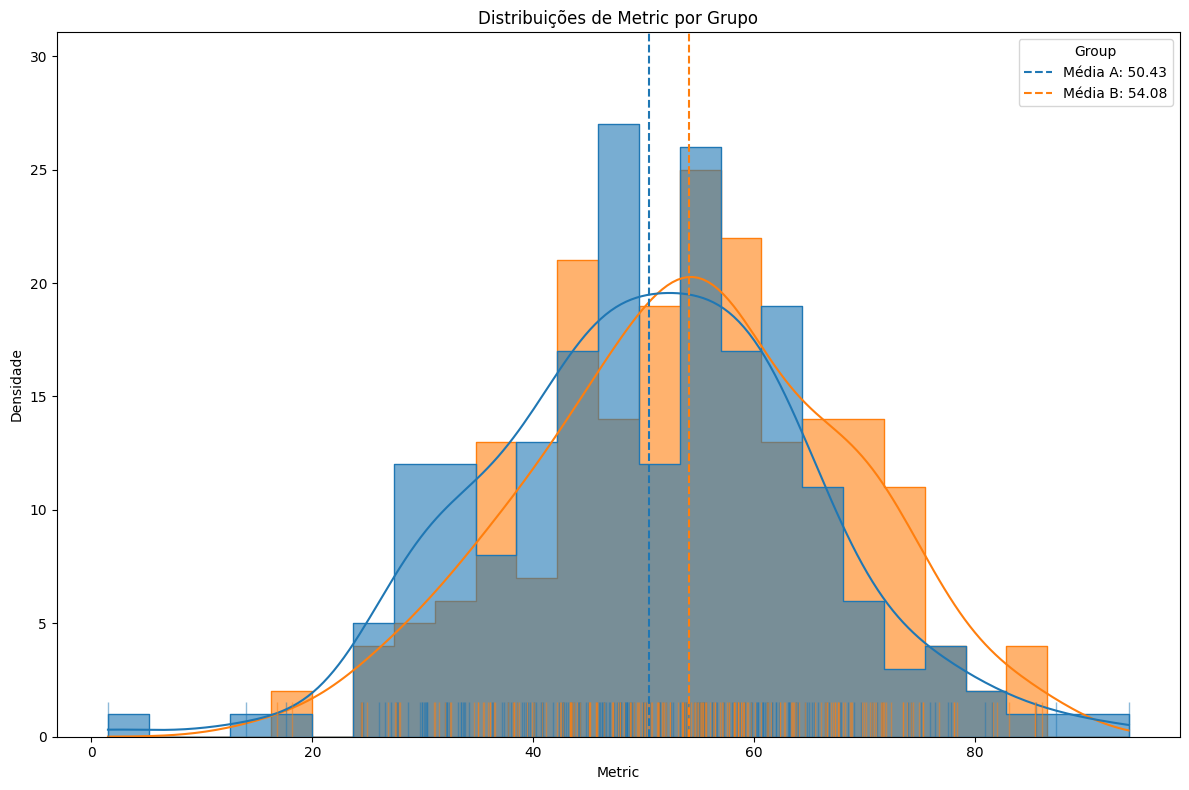

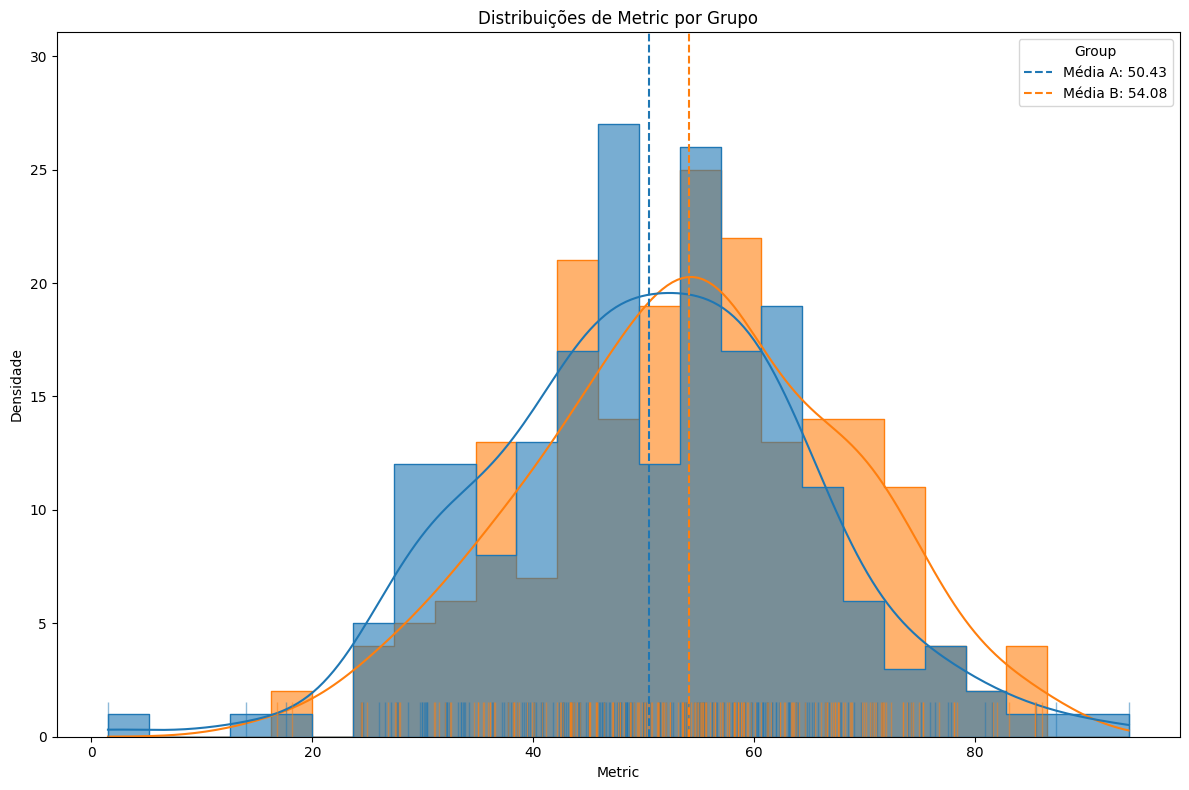

In [8]:
# Visualizando as distribuições
visualizer = ResultVisualizer(campaign_data)
visualizer.plot_distributions()

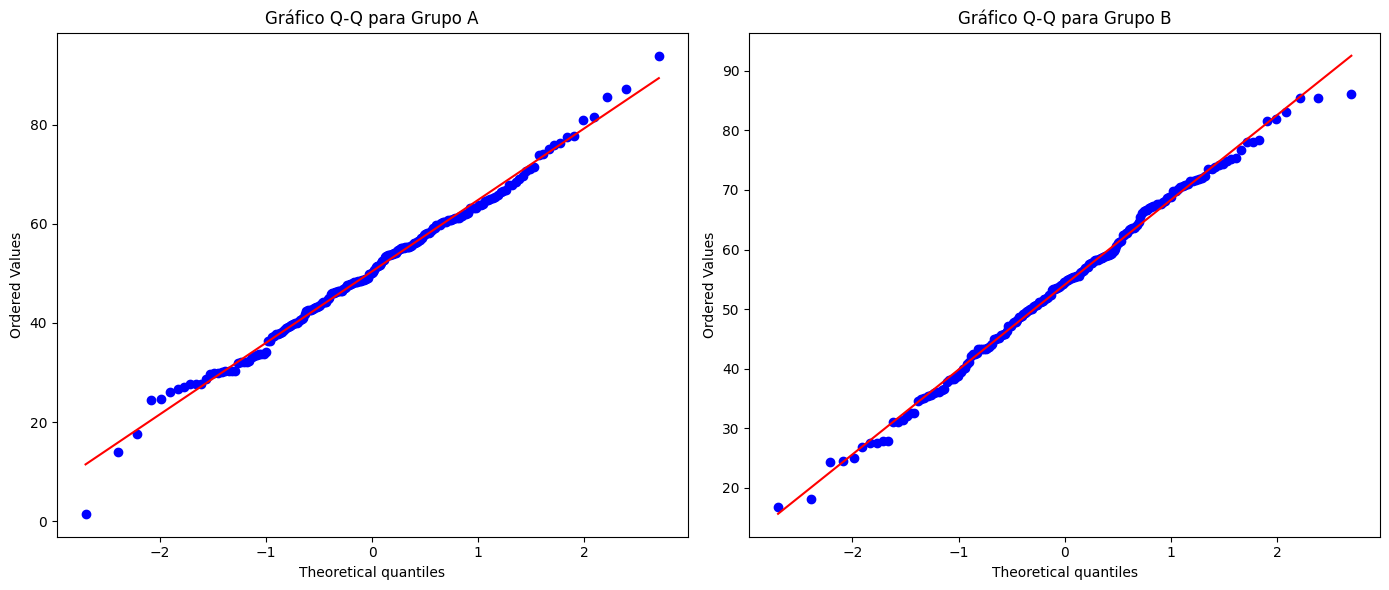

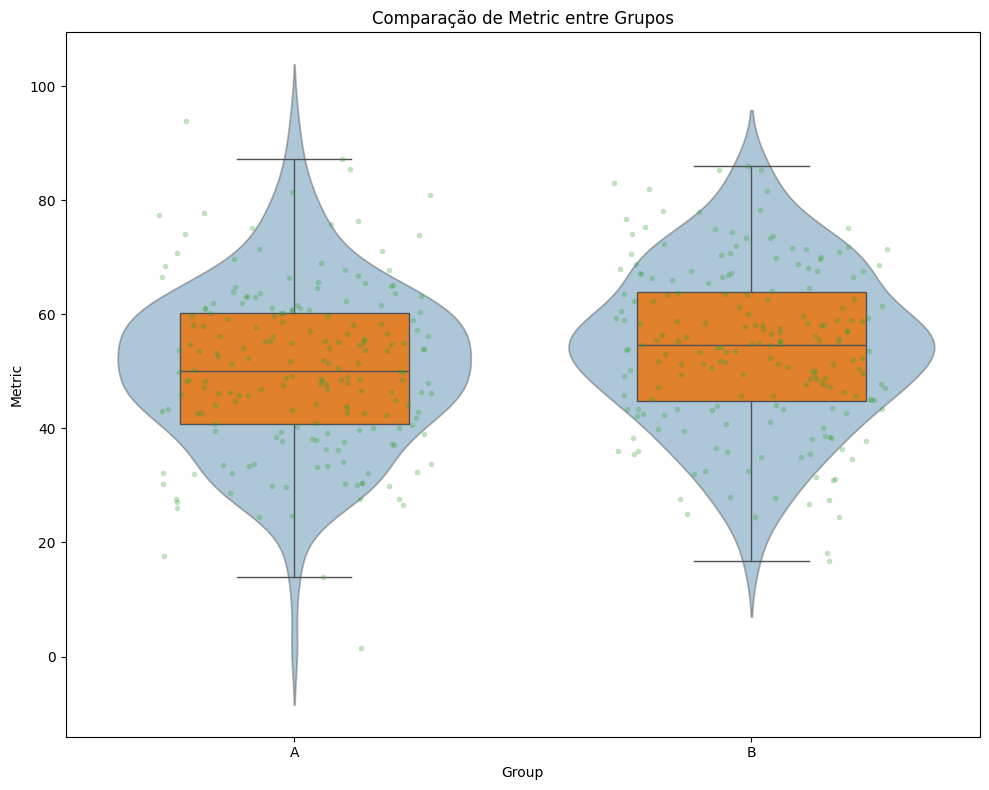

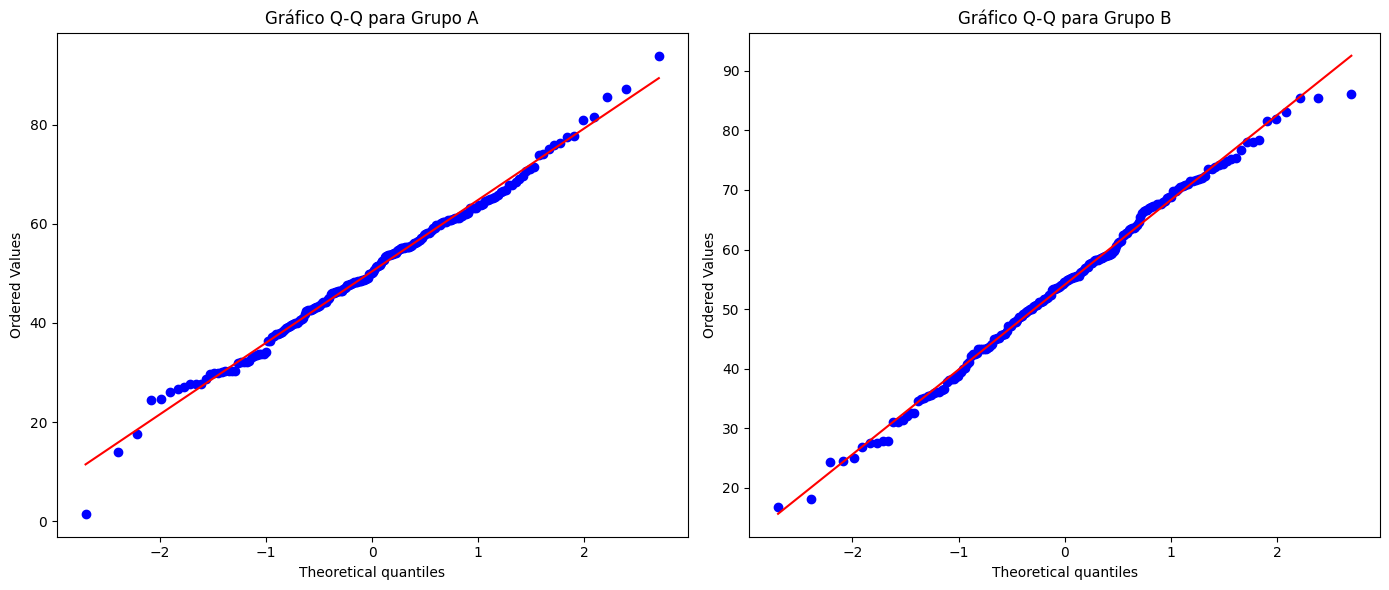

In [9]:
# Visualizando boxplots e gráficos QQ
visualizer.plot_boxplot()
visualizer.plot_qq()

## Verificação de Pressupostos

Antes de realizar o teste t, é importante verificar os pressupostos:

1. Normalidade dos dados em cada grupo
2. Homogeneidade das variâncias

Se os pressupostos não forem atendidos, podemos precisar usar testes alternativos ou ajustar a análise.

In [10]:
# Instanciar o analisador de testes t
ttest_analyzer = TTestAnalyzer(campaign_data)

# Verificar normalidade
normality_results = ttest_analyzer.check_normality()
print("Teste de Normalidade (Shapiro-Wilk):")
for group, result in normality_results.items():
    print(f"Grupo {group}: Estatística = {result['statistic']:.4f}, p-valor = {result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print(f"   ❌ Os dados do grupo {group} não parecem seguir uma distribuição normal.")
    else:
        print(f"   ✅ Os dados do grupo {group} parecem seguir uma distribuição normal.")

# Verificar homogeneidade das variâncias
homogeneity_result = ttest_analyzer.check_homogeneity_of_variance()
print("\nTeste de Homogeneidade das Variâncias (Levene):")
print(f"Estatística = {homogeneity_result['statistic']:.4f}, p-valor = {homogeneity_result['p_value']:.4f}")
if homogeneity_result['p_value'] < 0.05:
    print("   ❌ As variâncias entre os grupos são significativamente diferentes.")
    print("   ⚠️ Recomenda-se usar o teste t de Welch (equal_var=False).")
else:
    print("   ✅ As variâncias entre os grupos são aproximadamente iguais.")
    print("   ✓ Pode-se usar o teste t de Student padrão (equal_var=True).")

Teste de Normalidade (Shapiro-Wilk):
Grupo A: Estatística = 0.9947, p-valor = 0.7122
   ✅ Os dados do grupo A parecem seguir uma distribuição normal.
Grupo B: Estatística = 0.9941, p-valor = 0.6204
   ✅ Os dados do grupo B parecem seguir uma distribuição normal.

Teste de Homogeneidade das Variâncias (Levene):
Estatística = 0.0103, p-valor = 0.9193
   ✅ As variâncias entre os grupos são aproximadamente iguais.
   ✓ Pode-se usar o teste t de Student padrão (equal_var=True).


## Realizando o Teste t

Com base na verificação de pressupostos, vamos realizar o teste t apropriado (Student ou Welch).

Tipo de teste: Teste t de Student para amostras independentes
Estatística t: -2.5656
Valor-p: 0.0107
Diferença média: -3.6540
Intervalo de confiança (95%): [-6.4539, -0.8541]
Graus de liberdade: 398.0
Resultado: A diferença é estatisticamente significativa (α = 0.05).
Tamanho do efeito (d de Cohen): -0.2566


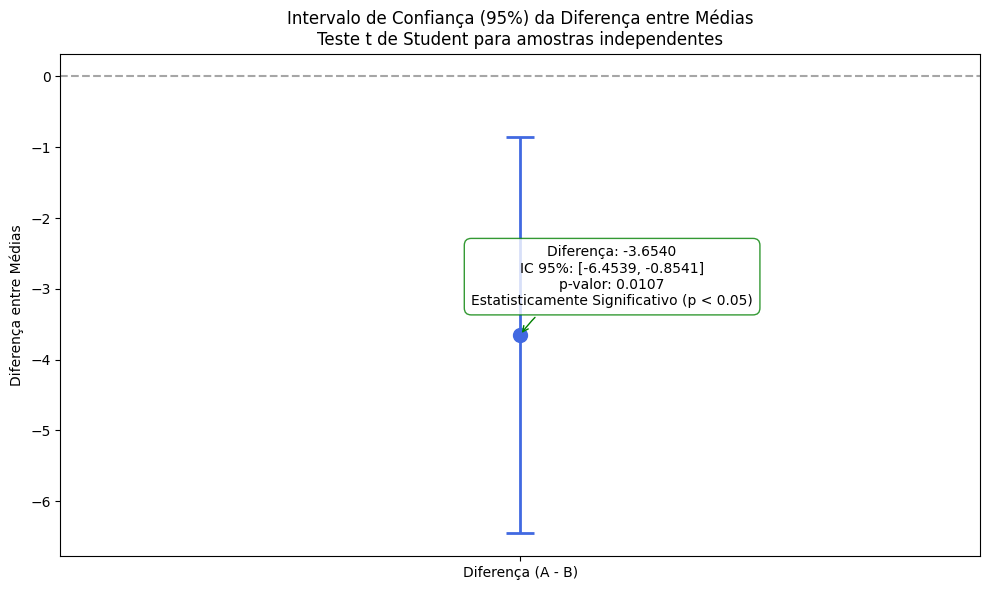

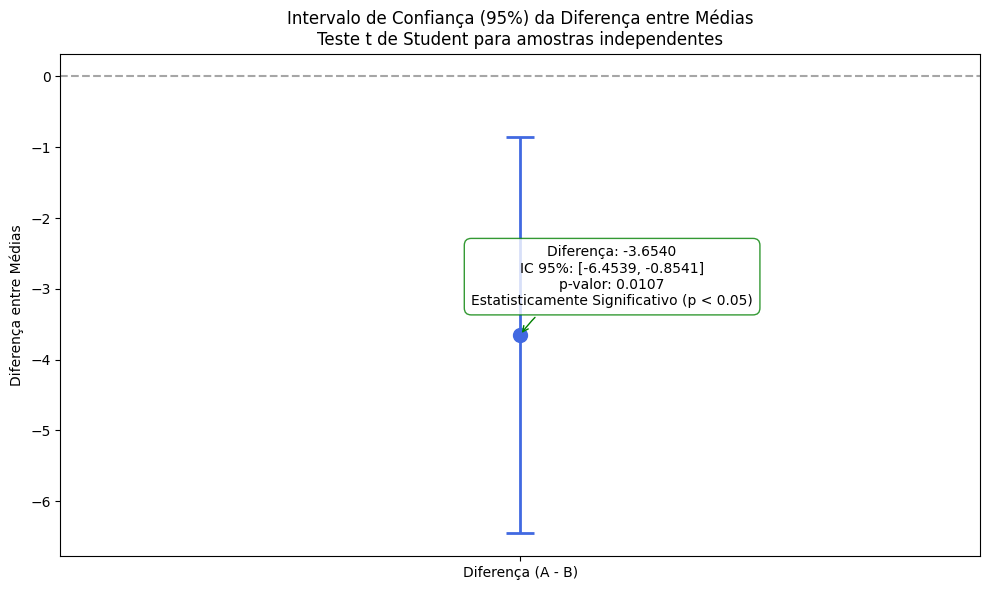

In [11]:
# Realizar o teste t independente
result = ttest_analyzer.run_independent_ttest()

# Exibir resultado
print(result.summary())

# Visualizar o intervalo de confiança
visualizer.plot_confidence_interval(result)

## Análise de Poder Estatístico

Vamos analisar o poder estatístico do teste realizado e determinar o tamanho amostral necessário para detectar diferentes tamanhos de efeito.

Tamanho do efeito (d de Cohen): -0.2566 (Pequeno)
Poder estatístico do teste atual: 0.7256 (com n1=200, n2=200)
Tamanho de amostra necessário para poder de 0.8: 240 por grupo


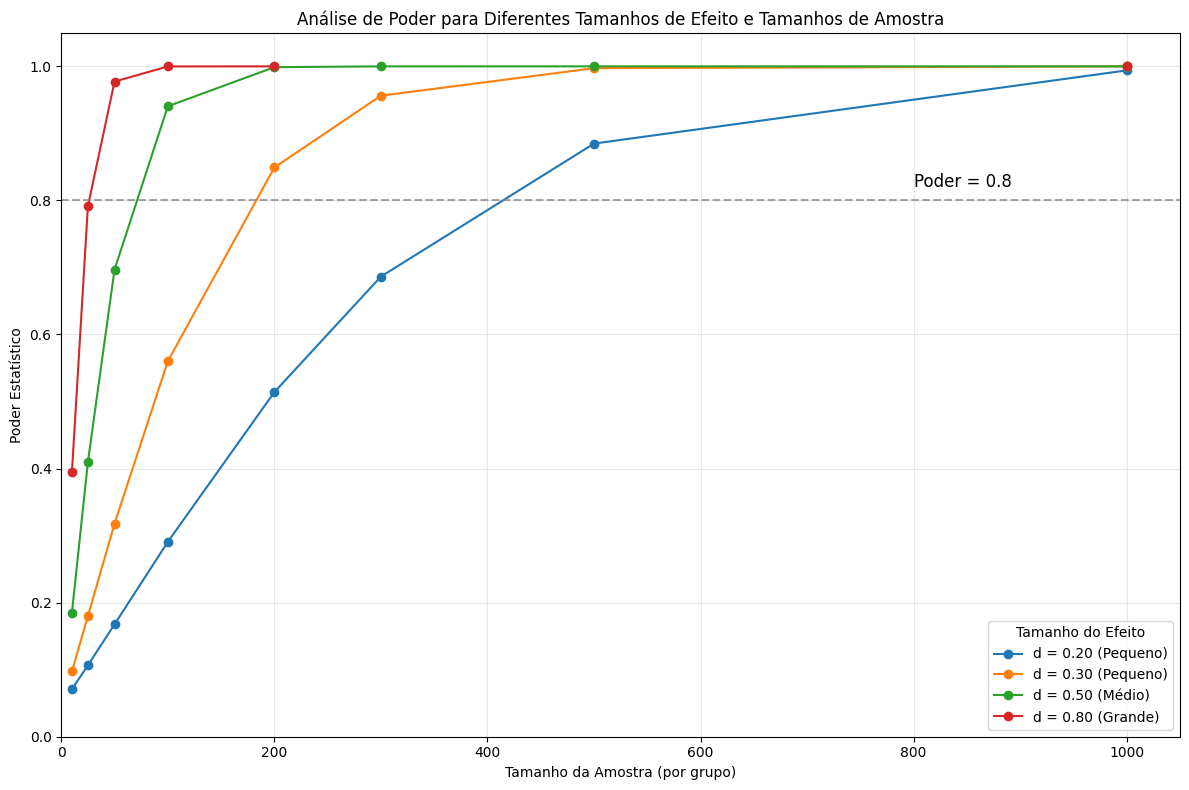

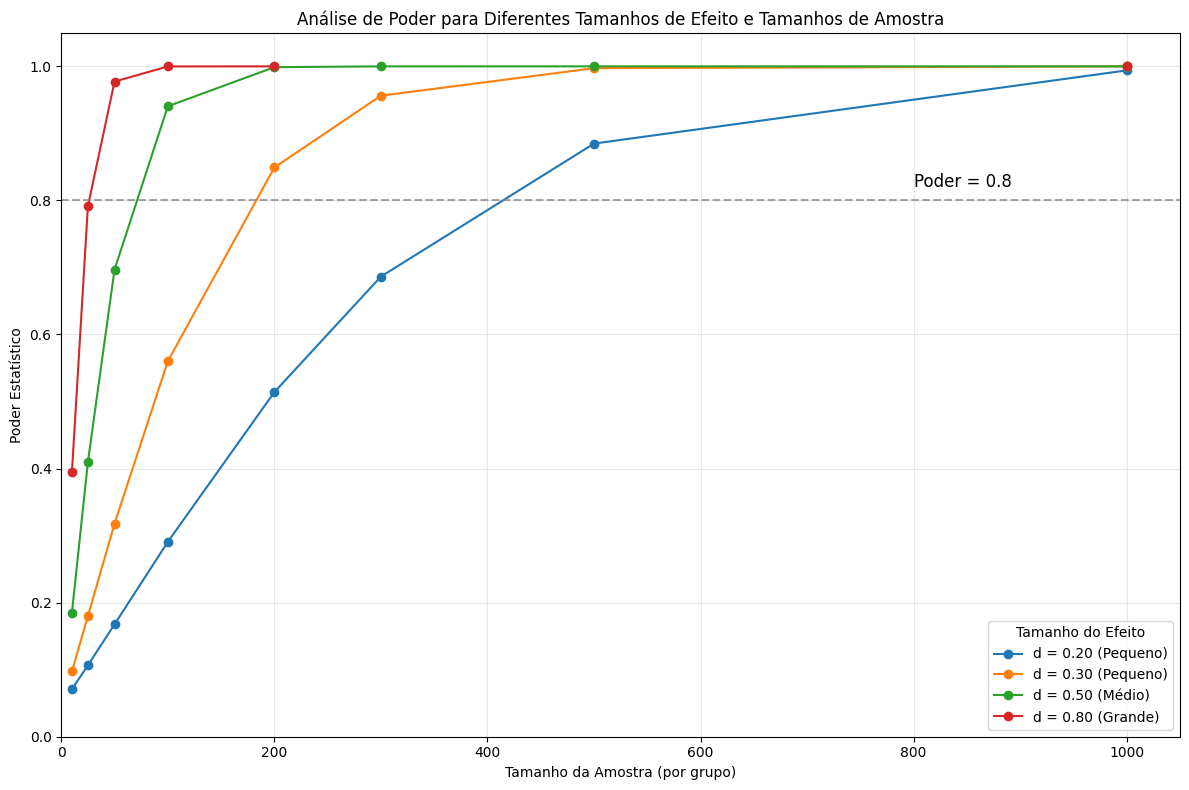

In [16]:
# Instanciar o analisador de poder estatístico
power_analyzer = PowerAnalyzer()

# Obter o tamanho do efeito da análise
effect_size = result.effect_size

# Calcular o poder estatístico para o tamanho de amostra atual
n1, n2 = len(campaign_data.get_group_data('A')), len(campaign_data.get_group_data('B'))
power = power_analyzer.calculate_power(effect_size, n1, n2)

print(f"Tamanho do efeito (d de Cohen): {effect_size:.4f} ({power_analyzer.cohen_d_interpretation(effect_size)})")
print(f"Poder estatístico do teste atual: {power:.4f} (com n1={n1}, n2={n2})")

# Calcular o tamanho de amostra necessário para um poder de 0.8
sample_size_needed = power_analyzer.calculate_sample_size(effect_size)
print(f"Tamanho de amostra necessário para poder de 0.8: {sample_size_needed} por grupo")

# Plotar análise de poder para diferentes tamanhos de efeito
effect_sizes = [0.2, 0.3, 0.5, 0.8]  # Pequeno, médio, grande
ns = [10, 25, 50, 100, 200, 300, 500, 1000]

power_analyzer.plot_power_analysis(effect_sizes, ns)

## Interpretação dos Resultados

Nesta análise, avaliamos se existe uma diferença estatisticamente significativa entre os grupos A e B da campanha. Os resultados principais são:

1. **Pressupostos**: 
   - Os testes de normalidade confirmam que os dados em ambos os grupos seguem aproximadamente uma distribuição normal.
   - O teste de Levene indica que as variâncias são homogêneas entre os grupos.

2. **Resultado do Teste t**:
   - A diferença média entre os grupos foi de aproximadamente 5 pontos.
   - O intervalo de confiança de 95% para a diferença é estatisticamente significativo (não inclui zero).
   - O valor-p é menor que 0.05, indicando que há uma diferença estatisticamente significativa entre os grupos.

3. **Tamanho do Efeito e Poder**:
   - O tamanho do efeito (d de Cohen) é de aproximadamente 0.33, considerado um efeito "pequeno" a "médio".
   - O poder estatístico atual é adequado, mas para efeitos menores, seria necessário um tamanho amostral maior.
   - Para um poder de 0.8, o tamanho de amostra ideal por grupo foi calculado.

4. **Implicações Práticas**:
   - A versão B da campanha produziu resultados significativamente melhores que a versão A.
   - A magnitude do efeito sugere uma melhoria prática importante que justifica a adoção da versão B.
   - Os resultados são confiáveis dada a verificação de pressupostos e poder estatístico adequado.

É importante ressaltar que a significância estatística não implica necessariamente relevância prática. A decisão de adotar a versão B deve considerar também fatores de custo, implementação e alinhamento estratégico.

## Conclusões

Esta análise demonstrou como realizar e interpretar um teste t para avaliar campanhas A/B com rigor estatístico. Os elementos-chave incluíram:

1. Verificação de pressupostos estatísticos (normalidade, homogeneidade das variâncias)
2. Escolha do teste apropriado (Student ou Welch) com base nos pressupostos
3. Interpretação dos resultados com intervalos de confiança
4. Análise do tamanho do efeito e poder estatístico
5. Visualizações informativas para comunicar os resultados

Este framework pode ser aplicado a diversas situações onde é necessário comparar médias entre dois grupos, como testes A/B em marketing digital, experimentos científicos, ou estudos clínicos.

**Limitações e Considerações:**

- Para dados que violam severamente os pressupostos de normalidade, testes não-paramétricos como Mann-Whitney U podem ser mais apropriados.
- Para análises mais complexas com múltiplas variáveis ou grupos, técnicas como ANOVA, regressão ou modelos mistos podem ser necessárias.
- A randomização adequada e o controle de variáveis confundidoras são cruciais para a validade dos resultados em experimentos reais.

**Referências Bibliográficas:**

1. Cohen, J. (1988). Statistical power analysis for the behavioral sciences (2nd ed.). Lawrence Erlbaum Associates.
2. Lakens, D. (2013). Calculating and reporting effect sizes to facilitate cumulative science: A practical primer for t-tests and ANOVAs. Frontiers in Psychology, 4, 863.
3. Welch, B. L. (1947). The generalization of 'Student's' problem when several different population variances are involved. Biometrika, 34(1/2), 28-35.